In [0]:
import tensorflow as tf
import matplotlib.pylab as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
# from tensorflow.keras import layers

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## part-1 use a tensorflow hub mobilenet for predictions

In [0]:
#download the classifier
CLASSIFIER_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])


## Run it on a single image

65536/61306 [================================] - 0s 0us/step


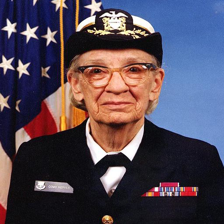

In [22]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

In [23]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [24]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [25]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

#decode the predictions

16384/10484 [==============================================] - 0s 0us/step


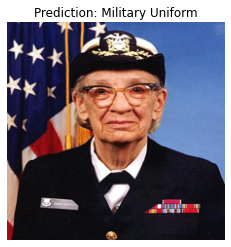

In [26]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

# Part 2: Use a TensorFlow Hub models for the Cats vs. Dogs dataset

In [27]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteANZCRN/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [28]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


In [0]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

# Run the classifier on a batch of images

In [30]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]x`
predicted_class_names

array(['kelpie', 'borzoi', 'German shepherd', 'Persian cat',
       'Egyptian cat', 'carton', 'beagle', 'tabby', 'Persian cat',
       'tabby', 'American Staffordshire terrier', 'cocker spaniel',
       'Egyptian cat', 'bloodhound', 'tabby', 'tabby', 'Shih-Tzu',
       'tabby', 'tiger cat', 'vizsla', 'Labrador retriever', 'malinois',
       'Siamese cat', 'Chihuahua', 'American Staffordshire terrier',
       'basenji', 'Egyptian cat', 'miniature pinscher', 'Egyptian cat',
       'Appenzeller', 'tiger cat', 'Egyptian cat'], dtype='<U30')

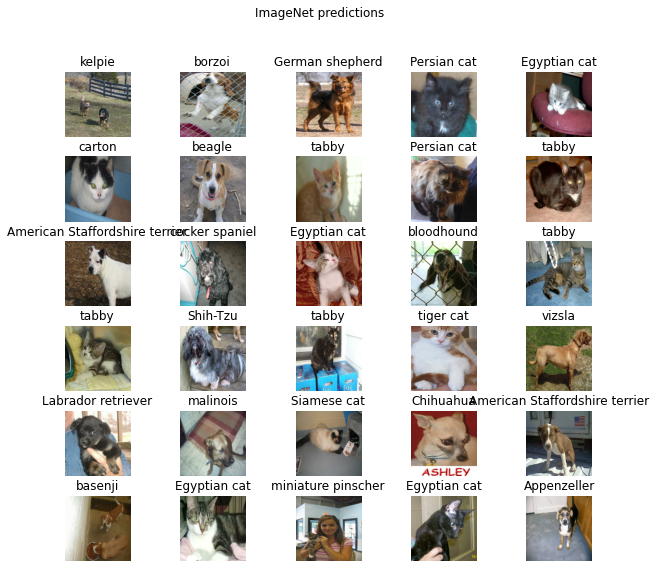

In [31]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

#Part 3: Do simple transfer learning with TensorFlow Hub

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES,3))

In [34]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
feature_extractor.trainable = False

# Attach a classification head

In [37]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_13 (KerasLayer)  (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


# Train the model

In [38]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 32s 55ms/step - loss: 0.3367 - accuracy: 0.9804 - val_loss: 0.3259 - val_accuracy: 0.9880
Epoch 2/6
582/582 [==============================] - 32s 56ms/step - loss: 0.3242 - accuracy: 0.9900 - val_loss: 0.3238 - val_accuracy: 0.9899
Epoch 3/6
582/582 [==============================] - 31s 54ms/step - loss: 0.3227 - accuracy: 0.9913 - val_loss: 0.3233 - val_accuracy: 0.9895
Epoch 4/6
582/582 [==============================] - 31s 53ms/step - loss: 0.3212 - accuracy: 0.9926 - val_loss: 0.3230 - val_accuracy: 0.9897
Epoch 5/6
582/582 [==============================] - 31s 53ms/step - loss: 0.3205 - accuracy: 0.9932 - val_loss: 0.3235 - val_accuracy: 0.9893
Epoch 6/6
582/582 [==============================] - 31s 54ms/step - loss: 0.3198 - accuracy: 0.9942 - val_loss: 0.3236 - val_accuracy: 0.9888


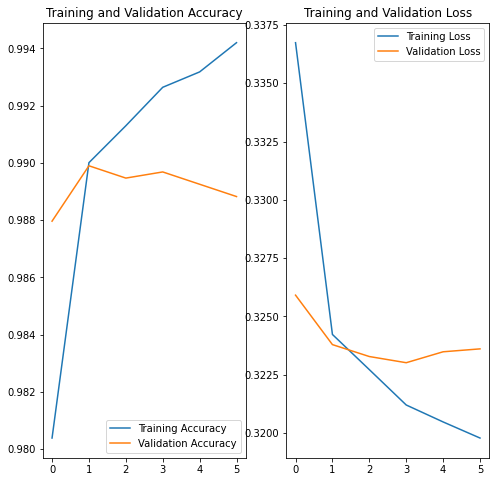

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Check the predictions

In [40]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [41]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat',
       'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat',
       'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat',
       'cat', 'cat', 'dog', 'cat', 'cat'], dtype='<U3')

In [44]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [1 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0]
Predicted labels:  [1 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0]


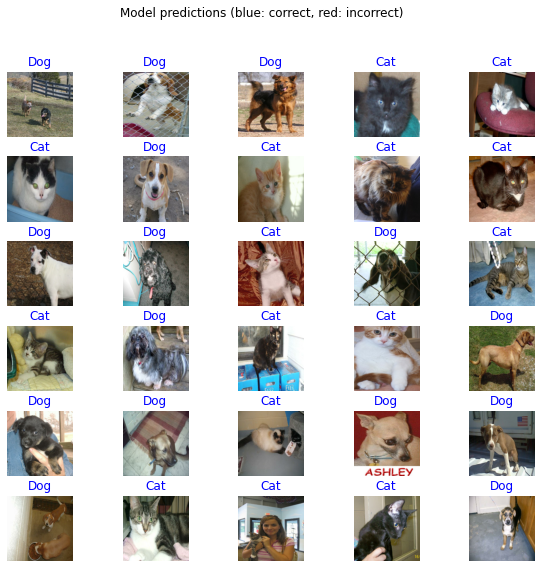

In [45]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")